In [2]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt
import graphviz
from sklearn.linear_model import LinearRegression
import rdata

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generalized Linear Habits

GLMs and GLMMs: Flexible association description machines

With external causal model, causal interpretation possible

But only a fraction of scientific phenomenca expressible as GLM(M)s

Even when GLM(M)s sufficient, starting with theory solves empirical problems

## Cartoon Human Volume

- Start with the approximation that humans are cylinders

- Most volume for a human comes from your height and your radius.

- $V = \pi r^2h$ V = volume, r = radius, h = height

- $V = \pi (ph)^2h$ radius as prportion of height

- $W = kV = k \pi (ph)^2h$ W = weight, k="density"

- $W = k \pi p^2 h^3$

- We have weight and height data

## Statistical model

$W_i \sim Distribution(\mu_i,...)$ 'error' distribution for W

$\mu_i = k \pi p^2 H^{3}_{i}$ Expected W for H 

$p \sim Distribution(...)$ prior for proportionality

$k \sim Distribution(...)$ prior for density

How to set priors?

1) Choose measurement scales
2) Simulate
3) Think

Units in the equation:

$\mu_i(kg) = k(kg/cm^3)H^{3}_{i}(cm^3)$

**Measurement scales are artifice**

If you can divide out all measurement scales (kg,cm), often easier

divide weight by mean weight and height by mean height

$p \sim Distribution(...)$ between 0-1, <0.5

$k \sim Distribution(...)$ positive real, >1

$p \sim Beta(25,50)$

$k \sim Exponential(0.5)$

In [6]:
np.pi

3.141592653589793

C:\Users\kiera\AppData\Local\Temp\ipykernel_10372\587324195.py:8: RuntimeWarning: divide by zero encountered in log
  mu = np.log(np.pi *k[i]*p[i]**2*xseq**3)


Text(0, 0.5, 'Weight (scaled)')

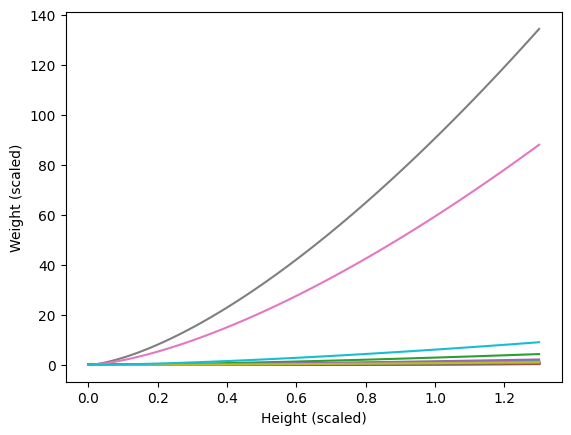

In [24]:
n = 30
p = np.random.beta(25,50,size=n)
k = np.random.exponential(0.5,size=n)
sigma = np.random.exponential(1,size=n)

xseq = np.linspace(0,1.3,num=100)
for i in range(n):
    mu = np.log(np.pi *k[i]*p[i]**2*xseq**3)
    plt.plot(xseq,np.exp((mu+sigma[i]**2)/2))
plt.xlabel('Height (scaled)')
plt.ylabel('Weight (scaled)')

$W_i \sim LogNormal(\mu_i,sigma)$ Growth is multiplication, log-normal is natural choice

$exp(\mu_i) = k \pi p^3 H^{3}_{i}$ mu in log-normal is mean of log, not mean of observed

$p \sim Beta(25,50)$

$k \sim Exponential(0.5)$

In [29]:
howell = pd.read_csv('Data/Howell1.csv',sep=';')
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [48]:
with pm.Model() as m161:
    H = pm.MutableData('H',howell['height'].values/howell['height'].mean())
    Wobs = pm.MutableData('Wobs',howell['weight'].values/howell['weight'].mean())

    
    k = pm.Exponential('k',0.5)
    p = pm.Beta('p',25,50)
    sigma = pm.Exponential('sigma',1)
    mu = np.log(np.pi*k *(p**2) * (H**3))
    W = pm.LogNormal('W',mu,sigma,observed=Wobs)
    m161_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.


In [49]:
with m161:
    pm.sample_posterior_predictive(m161_trace,extend_inferencedata=True)

Sampling: [W]


In [50]:
m161_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [51]:
az.hdi(m161_trace.posterior_predictive.W)

<xarray.Dataset>
Dimensions:  (W_dim_2: 544, hdi: 2)
Coordinates:
  * W_dim_2  (W_dim_2) int32 0 1 2 3 4 5 6 7 ... 536 537 538 539 540 541 542 543
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    W        (W_dim_2, hdi) float64 0.8229 1.803 0.6313 ... 0.1837 0.922 2.023

Text(0, 0.5, 'weight (scaled)')

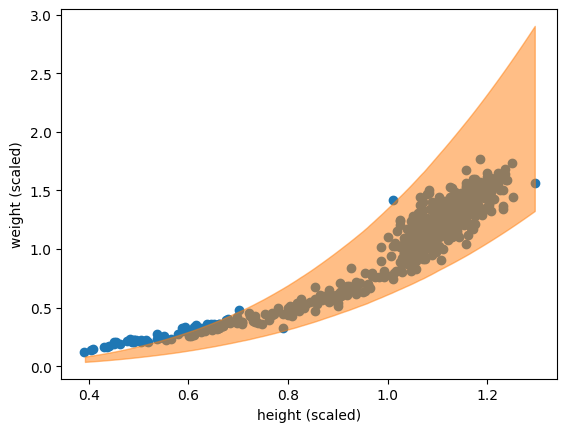

In [52]:
H = howell['height'].values/howell['height'].mean()
plt.scatter(x=H,y=howell['weight'].values/howell['weight'].mean())
az.plot_hdi(x=H,y=m161_trace.posterior_predictive.W)
plt.xlabel('height (scaled)')
plt.ylabel('weight (scaled)')

## Insightful errors

Not bad for a cylinder

Poor fit for children

In scientific model, poor fit is informative - p different for kids

Bad epicycles harder to read 

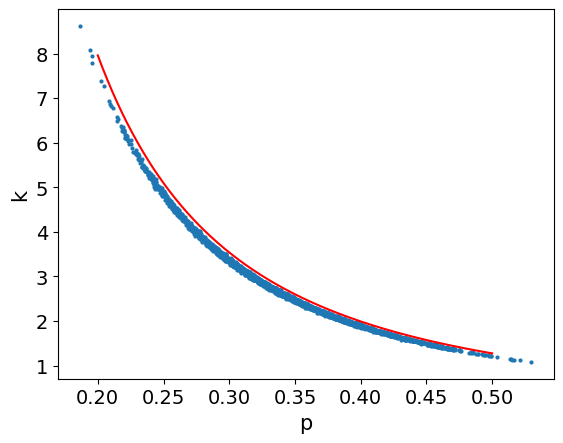

In [62]:
az.plot_pair(m161_trace,var_names =['p','k'])
p = np.linspace(0.2,0.5,400)
k = 1/(np.pi*p**2)
plt.plot(p,k,c='r')

Observe the curve that expresses the relationship between k and p. These parameters are completely unnecessary!

$\mu_i = k \pi p^2 H^{3}_{i}$

$(1) = k \pi p^2 (1)^3$ inserting mean value

$k = 1/{\pi p^2}$

$(1) = \pi \theta (1)^3$

$ \theta \approx \pi^-1$

In dimensionless model, W is H^3
There are no free parameters in this model!

In [63]:
with pm.Model() as MWH2:
    H = pm.MutableData('H',howell['height'].values/howell['height'].mean())
    Wobs = pm.MutableData('Wobs',howell['weight'].values/howell['weight'].mean())

    sigma = pm.Exponential('sigma', 1)
    mu = np.log(H**3)
    W = pm.LogNormal('W',mu,sigma,observed=Wobs)
    MWH2_trace = pm.sample()
    pm.sample_posterior_predictive(MWH2_trace,extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Sampling: [W]


Text(0, 0.5, 'weight (scaled)')

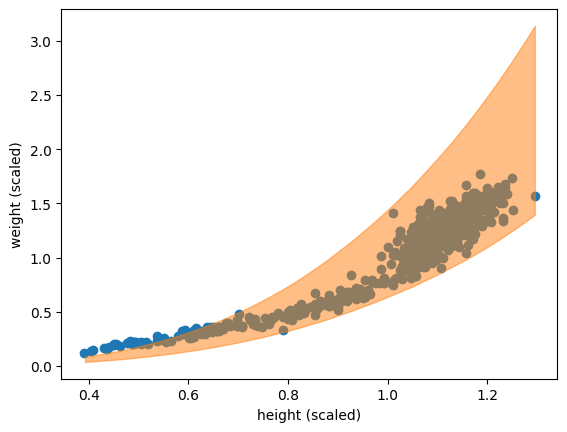

In [64]:
H = howell['height'].values/howell['height'].mean()
plt.scatter(x=H,y=howell['weight'].values/howell['weight'].mean())
az.plot_hdi(x=H,y=MWH2_trace.posterior_predictive.W)
plt.xlabel('height (scaled)')
plt.ylabel('weight (scaled)')

## Geometric People

Most of the relationship H -> W is just relationship between length and volume

Changes in body shape explain poor fit for childrend?

Problems provide insight when model is scientific instead of purely statistical 

There is no empiricism without theory

## Social Conformity ##

Do children copy the majority? If so, how does this develop?

Problem: Cannot see strategy, only choice

Majority choice consistent with many strategies

Random color: Choose majority 1/3 of time

Random demonstrator: 3/4 of time

Random demonstration: 1/2 of time

In [105]:
#Simulation

n = 100 #Number of children

#Half choose random color
#Sample from 1,2,3 at random for each
y1 = np.random.choice(a=[0,1,2],size=int(n/2),replace=True)

#Half follow majority
y2 = (np.ones(50) *2).astype(int)

y = np.concatenate((y1,y2))
y = np.random.shuffle(y)

## State-Based Model

Majority choice does not indicate majority preference 

Instead infer the unobserved strategy (state) of each child

Strategy space:
1) Majority
2) Minority
3) Maverick
4) Random Color
5) Follow first